In [1]:
import numpy as np
import pandas as pd
import gc
from tqdm import tqdm
from loguru import logger
from matplotlib import pyplot as plt
from source.utils.file_read import process_and_concat_files 
from source.utils.file_read import filter_df
from source.utils.generate_timestamp import generate_timestamps
from source.forecasters.deterministic import create_day_ahead_predictions, create_day_ahead_11_predictions, create_week_ahead_predictions
from source.forecasters.probabilistic import create_day_ahead_quantiles10, create_day_ahead_11_quantiles10, create_week_ahead_quantiles10
from source.forecasters.probabilistic import create_day_ahead_quantiles90, create_day_ahead_11_quantiles90, create_week_ahead_quantiles90
from source.ensemble.stack_generalization.utils.display_results import display_forecasting_metrics
from source.ensemble.combination_scheme.equal_weights import calculate_equal_weights
from source.ensemble.combination_scheme.avg_weights import calculate_weighted_avg
from source.ensemble.utils.metrics import calculate_rmse, calculate_pinball_losses
from source.plots.plot_forecasts import plot_ensemble_forecasts, plot_var_ensemble_forecasts, plot_ramp_events, plot_weighted_avg_forecasts
from source.plots.plot_hypothesis_testing import plot_statistical_comparison, transform_loss_lists_to_df
from source.ensemble.combination_scheme.weight_avg_plot_importance import plot_weight_avg_contributions
from sklearn.utils.fixes import parse_version, sp_version
solver = "highs" if sp_version >= parse_version("1.6.0") else "interior-point"

In [2]:
from config.simulation_setting import Simulation, WeightedAvg, Stack

sim_params = Simulation.testing_period
weight_avg_params = WeightedAvg.params
ens_params = Stack.params
ens_params

{'save_info': './info_model/',
 'save_file': 'previous_day.pickle',
 'normalize': False,
 'compute_abs_difference': False,
 'add_quantile_predictions': False,
 'augment_q50': False,
 'nr_cv_splits': 5,
 'quantiles': [0.1, 0.9, 0.5],
 'max_lags': 3,
 'forecasters_diversity': False,
 'lagged': True,
 'augment': False,
 'differenciate': False,
 'max_lags_var': 3,
 'augment_var': False,
 'baseline_model': 'diff_norm_dayahead',
 'model_type': 'LR',
 'var_model_type': 'LR',
 'gbr_update_every_days': 30,
 'gbr_config_params': {'learning_rate': [0.001, 0.005, 0.01],
  'max_features': [0.85, 0.95, 1.0],
  'max_depth': [3, 4],
  'max_iter': [250, 500, 750, 1000]},
 'lr_config_params': {'alpha': [1e-05, 0.0001, 0.001, 0.005],
  'fit_intercept': [True, False]},
 'order_diff': 1,
 'var_gbr_config_params': {'learning_rate': [0.001, 0.005, 0.01],
  'max_features': [0.85, 0.95, 1.0],
  'max_depth': [3, 4],
  'max_iter': [150, 300, 450]},
 'var_lr_config_params': {'alpha': [1e-05, 0.0001, 0.001, 0.005]

In [3]:
from source.utils.data_preprocess import normalize_dataframe

def process_combination_scheme(params, df_train, df_test, df_buyer, start_prediction_timestamp):
    " Process data for the combination scheme"
    # Concatenate train and test dataframes
    df_comb_scheme = pd.concat([df_train, df_test], axis=0)
    # Get the maximum capacity
    maximum_capacity = df_buyer['b1r1'].max()
    # Normalize dataframe
    if params['normalize']:
        df_comb_scheme_norm = normalize_dataframe(df_comb_scheme, maximum_capacity)
    else:
        df_comb_scheme_norm = df_comb_scheme.copy()
        df_comb_scheme_norm= df_comb_scheme_norm.add_prefix('norm_')
    # Differentiate dataframe
    df_comb_scheme_norm_diff = df_comb_scheme_norm.copy()
    lst_cols_diff = ['diff_' + name for name in df_comb_scheme_norm.columns]
    df_comb_scheme_norm_diff.columns = lst_cols_diff
    # Split train and test dataframes
    df_train_norm_diff = df_comb_scheme_norm_diff[df_comb_scheme_norm_diff.index < start_prediction_timestamp]
    df_test_norm_diff = df_comb_scheme_norm_diff[df_comb_scheme_norm_diff.index >= start_prediction_timestamp]
    return df_train_norm_diff, df_test_norm_diff

Testing Days:   0%|          | 0/80 [00:00<?, ?it/s]2024-06-25 09:59:07.731 | INFO     | __main__:<module>:66 -  
2024-06-25 09:59:07.731 | INFO     | __main__:<module>:67 - -------------------------------------------------------------------------------------------
2024-06-25 09:59:07.731 | INFO     | __main__:<module>:68 - Start prediction: 2023-03-26 00:00:00+00:00 - End prediction: 2023-03-27 00:00:00+00:00
2024-06-25 09:59:07.734 | INFO     | __main__:<module>:73 -  
2024-06-25 09:59:07.734 | INFO     | __main__:<module>:74 -  -----------------> Forecasters prediction submitted 
2024-06-25 09:59:08.029 | INFO     | source.ml_engine:create_ensemble_forecasts:37 -   
2024-06-25 09:59:08.029 | INFO     | source.ml_engine:create_ensemble_forecasts:38 -  PREDICO Machine Learning Engine  
2024-06-25 09:59:08.030 | INFO     | source.ml_engine:create_ensemble_forecasts:39 -   
2024-06-25 09:59:08.030 | INFO     | source.ml_engine:create_ensemble_forecasts:40 -  Predictions from 2023-03-26 

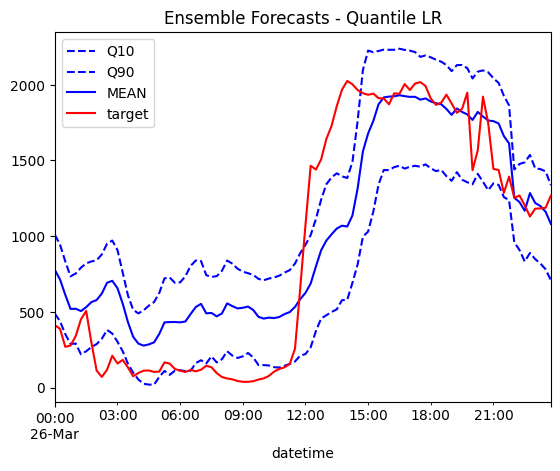

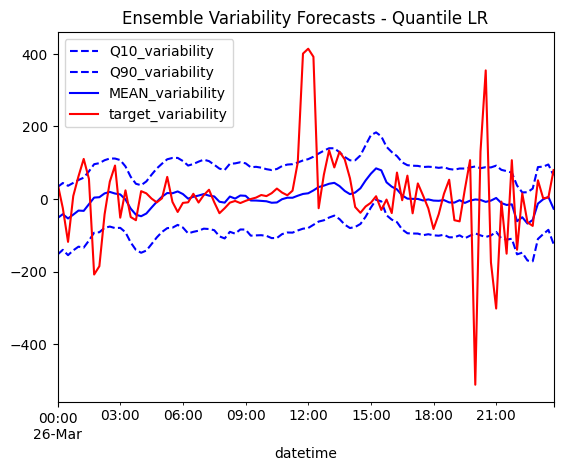

2024-06-25 09:59:09.737 | INFO     | source.ensemble.stack_generalization.utils.display_results:display_forecasting_metrics:12 -  
2024-06-25 09:59:09.738 | INFO     | source.ensemble.stack_generalization.utils.display_results:display_forecasting_metrics:13 - ------------- Wind Power Forecasting ------------------------------
2024-06-25 09:59:09.738 | INFO     | source.ensemble.stack_generalization.utils.display_results:display_forecasting_metrics:14 - ----------------- RMSE -----------------
2024-06-25 09:59:09.739 | INFO     | source.ensemble.stack_generalization.utils.display_results:display_forecasting_metrics:15 - GBR Stacked 373.414
2024-06-25 09:59:09.739 | INFO     | source.ensemble.stack_generalization.utils.display_results:display_forecasting_metrics:16 - Weighted Average 392.659
2024-06-25 09:59:09.739 | INFO     | source.ensemble.stack_generalization.utils.display_results:display_forecasting_metrics:17 - Equal Weights 464.963
2024-06-25 09:59:09.740 | INFO     | source.ense

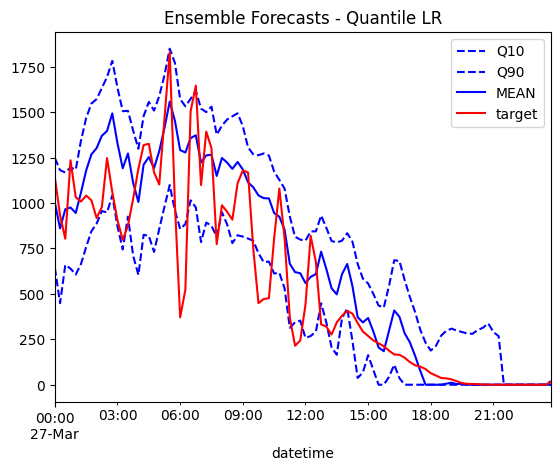

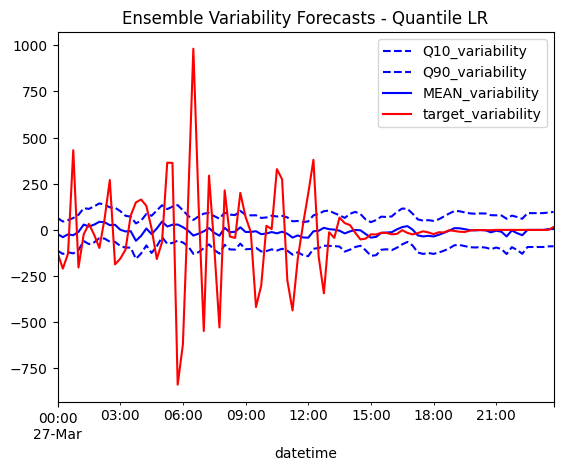

2024-06-25 09:59:11.668 | INFO     | source.ensemble.stack_generalization.utils.display_results:display_forecasting_metrics:12 -  
2024-06-25 09:59:11.669 | INFO     | source.ensemble.stack_generalization.utils.display_results:display_forecasting_metrics:13 - ------------- Wind Power Forecasting ------------------------------
2024-06-25 09:59:11.669 | INFO     | source.ensemble.stack_generalization.utils.display_results:display_forecasting_metrics:14 - ----------------- RMSE -----------------
2024-06-25 09:59:11.669 | INFO     | source.ensemble.stack_generalization.utils.display_results:display_forecasting_metrics:15 - GBR Stacked 245.278
2024-06-25 09:59:11.670 | INFO     | source.ensemble.stack_generalization.utils.display_results:display_forecasting_metrics:16 - Weighted Average 402.317
2024-06-25 09:59:11.670 | INFO     | source.ensemble.stack_generalization.utils.display_results:display_forecasting_metrics:17 - Equal Weights 412.576
2024-06-25 09:59:11.670 | INFO     | source.ense

KeyboardInterrupt: 

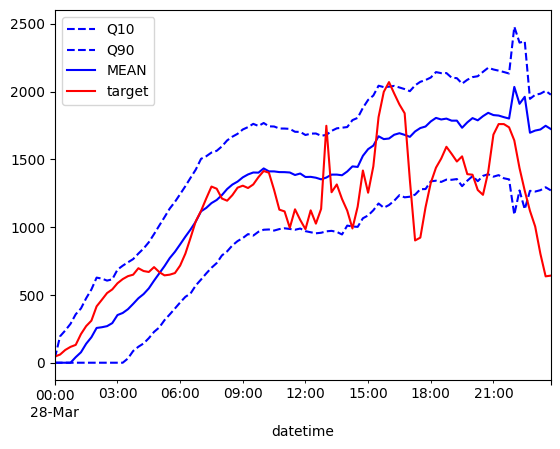

In [4]:
# set random seed
np.random.seed(42)

files = [sim_params['file_0'], sim_params['file_1'], sim_params['file_2'], sim_params['file_3'], sim_params['file_4']]
df = process_and_concat_files(files)

# get the maximum capacity
maximum_capacity = df.measured.max()

df_filtered = filter_df(df, sim_params['forecasts_col'], sim_params['measured_col'])

# loss quantile gradient boosting regressor
lst_rmse_gbr_ensemble = []
# loss equal weights scheme
lst_rmse_equal_weights = []
# loss weighted average scheme
lst_rmse_weighted_avg = []
# loss baseline day ahead
lst_rmse_baseline_dayahead = []
# loss baseline day ahead 11
lst_rmse_baseline_dayahead11h = []
# loss baseline week ahead
lst_rmse_baseline_week_ahead = []


if not ens_params['compute_abs_difference']:
    
    # loss var gradient boosting regressor
    lst_rmse_var_gbr_ensemble = []
    # loss var equal weights scheme
    lst_rmse_var_equal_weights = []
    # loss var weighted average scheme
    lst_rmse_var_weighted_avg = []
    # loss var baseline day ahead
    lst_rmse_var_baseline_dayahead = []
    # loss var baseline day ahead 11
    lst_rmse_var_baseline_dayahead11h = []
    # loss var baseline week ahead
    lst_rmse_var_baseline_week_ahead = []

    # loss quantile gradient boosting regressor
    lst_pb_gbr_ensemble_q10 = []
    lst_pb_gbr_ensemble_q90 = []
    # loss equal weights scheme
    lst_pb_weighted_avg_q10 = []
    lst_pb_weighted_avg_q90 = []
    # loss weighted average scheme
    lst_pb_equal_weights_q10 = []
    lst_pb_equal_weights_q90 = []
    # loss baseline day ahead
    lst_pb_dayahead_q10 = []
    lst_pb_dayahead_q90  = []
    # loss baseline day ahead 11
    lst_pb_dayahead_11h_q10 = []
    lst_pb_dayahead_11h_q90 = []
    # loss baseline week ahead
    lst_pb_week_ahead_q10 = []
    lst_pb_week_ahead_q90 = []

# loop over test days
for i in tqdm(range(sim_params['num_test_days']), desc='Testing Days'):

    # generate timestamps train and prediction
    start_training_timestamp, end_training_timestamp, start_prediction_timestamp, end_prediction_timestamp = generate_timestamps(sim_params['start_training'], i, sim_params['window_size'])

    logger.info(' ')
    logger.opt(colors = True).info('<blue>-------------------------------------------------------------------------------------------</blue>')
    logger.opt(colors = True).info(f'<blue>Start prediction: {start_prediction_timestamp} - End prediction: {end_prediction_timestamp}</blue>')

    df_train = df_filtered[df_filtered.index.to_series().between(start_training_timestamp, end_training_timestamp)].iloc[:-1,:]
    df_test = df_filtered[df_filtered.index.to_series().between(start_prediction_timestamp, end_prediction_timestamp)].iloc[:-1,:]

    logger.info(' ')
    logger.opt(colors = True).info('<blue> -----------------> Forecasters prediction submitted </blue>')
    
    # forecaster - day ahead forecast
    df_day_ahead_pred_train = create_day_ahead_predictions(df_train)
    df_day_ahead_pred_test = create_day_ahead_predictions(df_test)

    # forecaster - day ahead 11 forecast
    df_day_ahead11_pred_train = create_day_ahead_11_predictions(df_train)
    df_day_ahead11_pred_test = create_day_ahead_11_predictions(df_test)

    # forecaster - week ahead forecast
    df_week_ahead_pred_train = create_week_ahead_predictions(df_train)
    df_week_ahead_pred_test = create_week_ahead_predictions(df_test)

    # forecaster - day ahead quantile-10
    df_day_ahead_q10_train = create_day_ahead_quantiles10(df_train)
    df_day_ahead_q10_test = create_day_ahead_quantiles10(df_test)

    # forecaster - day ahead 11 quantile-10
    df_day_ahead11_q10_train = create_day_ahead_11_quantiles10(df_train)
    df_day_ahead11_q10_test = create_day_ahead_11_quantiles10(df_test)

    # forecaster - week ahead quantile-10
    df_week_ahead_q10_train = create_week_ahead_quantiles10(df_train)
    df_week_ahead_q10_test = create_week_ahead_quantiles10(df_test)

    # forecaster - day ahead quantile-90
    df_day_ahead_q90_train = create_day_ahead_quantiles90(df_train)
    df_day_ahead_q90_test = create_day_ahead_quantiles90(df_test)

    # forecaster - day ahead 11 quantile-90
    df_day_ahead11_q90_train = create_day_ahead_11_quantiles90(df_train)
    df_day_ahead11_q90_test = create_day_ahead_11_quantiles90(df_test)

    # forecaster - week ahead quantile-90
    df_week_ahead_q90_train = create_week_ahead_quantiles90(df_train)
    df_week_ahead_q90_test = create_week_ahead_quantiles90(df_test)


    from source.ml_engine import create_ensemble_forecasts

# # ----------------------------> SELLERS DATA <----------------------------
    # sellers data
    df_train_ensemble_quantile50 = pd.concat([df_day_ahead_pred_train, df_day_ahead11_pred_train, df_week_ahead_pred_train], axis=1)
    df_test_ensemble_quantile50 = pd.concat([df_day_ahead_pred_test, df_day_ahead11_pred_test, df_week_ahead_pred_test], axis=1)
    df_ensemble_quantile50 = pd.concat([df_train_ensemble_quantile50, df_test_ensemble_quantile50], axis=0)

    df_train_ensemble_quantile10 = pd.concat([df_day_ahead_q10_train, df_day_ahead11_q10_train, df_week_ahead_q10_train], axis=1)
    df_test_ensemble_quantile10 = pd.concat([df_day_ahead_q10_test, df_day_ahead11_q10_test, df_week_ahead_q10_test], axis=1)
    df_ensemble_quantile10 = pd.concat([df_train_ensemble_quantile10, df_test_ensemble_quantile10], axis=0)

    df_train_ensemble_quantile90 = pd.concat([df_day_ahead_q90_train, df_day_ahead11_q90_train, df_week_ahead_q90_train], axis=1)
    df_test_ensemble_quantile90 = pd.concat([df_day_ahead_q90_test, df_day_ahead11_q90_test, df_week_ahead_q90_test], axis=1)
    df_ensemble_quantile90 = pd.concat([df_train_ensemble_quantile90, df_test_ensemble_quantile90], axis=0)

    df_ensemble_quantile50.columns = ['s1_q50_b1r1', 's2_q50_b1r1', 's3_q50_b1r1']
    df_ensemble_quantile10.columns = ['s1_q10_b1r1', 's2_q10_b1r1', 's3_q10_b1r1']
    df_ensemble_quantile90.columns = ['s1_q90_b1r1', 's2_q90_b1r1', 's3_q90_b1r1']

    df_market = pd.concat([df_ensemble_quantile50, df_ensemble_quantile10, df_ensemble_quantile90], axis=1)

# # ----------------------------> BUYERS DATA <----------------------------
    df_train_buyer = pd.DataFrame(df_train['measured'])
    df_test_buyer = pd.DataFrame(df_test['measured'])
    forecast_range = pd.date_range(start=start_prediction_timestamp, end=end_prediction_timestamp, freq='15min')
    #df_test['measured'] = [None for i in range(len(df_test))]
    df_buyer = pd.concat([df_train_buyer, df_test_buyer], axis=0)
    df_buyer['b1r1'] = df_buyer['measured']
    df_buyer.drop(columns=['measured'], inplace=True)


# # ----------------------------> PREDICO PLATFORM ML ENGINE <----------------------------
    results_ensemble_forecasts = create_ensemble_forecasts(ens_params=ens_params,
                                    df_buyer=df_buyer, 
                                    df_market=df_market,
                                    forecast_range = forecast_range,
                                    challenge_usecase='simulation',
                                    simulation=True)
    
    df_pred_ensemble = results_ensemble_forecasts['wind_power']['predictions']
    df_pred_ensemble.rename(columns={'q50_' + 'b1r1': '50_predictions', 'q10_' + 'b1r1': '10_predictions', 'q90_' + 'b1r1': '90_predictions', 'diff_norm_' + 'b1r1': 'target'}, inplace=True)
    df_var_ensemble = results_ensemble_forecasts['wind_power_variability']['predictions']
    df_var_ensemble.rename(columns={'q50_' + 'b1r1': '50_var_predictions', 'q10_' + 'b1r1': '10_var_predictions', 'q90_' + 'b1r1': '90_var_predictions', 'targets': 'target'}, inplace=True)
    df_test_ensemble = results_ensemble_forecasts['wind_power']['df_test']
    df_2stage_test = results_ensemble_forecasts['wind_power_variability']['df_test']

# # ----------------------------> COMBINATION SCHEME DATA <----------------------------
    df_train_norm_diff, df_test_norm_diff = process_combination_scheme(ens_params, df_train, df_test, df_buyer, start_prediction_timestamp)


# # ----------------------------> PERFORMANCE METRICS <----------------------------
    # performance ensemble
    rmse_ensemble = round(calculate_rmse(df_pred_ensemble, '50_predictions').values[0][0], 3)
    lst_rmse_gbr_ensemble.append(rmse_ensemble)
    if not ens_params['compute_abs_difference']:
        pinball_ensemble = calculate_pinball_losses(df_pred_ensemble, '10_predictions', '90_predictions')
        pinball_ensemble_q10 = round(pinball_ensemble['pb_loss_10'].values[0], 3)
        pinball_ensemble_q90 = round(pinball_ensemble['pb_loss_90'].values[0], 3)
        lst_pb_gbr_ensemble_q10.append(pinball_ensemble_q10)
        lst_pb_gbr_ensemble_q90.append(pinball_ensemble_q90)

    if not ens_params['compute_abs_difference']:
        # performance variability ensemble
        rmse_var_ensemble = round(calculate_rmse(df_var_ensemble, '50_var_predictions', targ_col='target').values[0][0], 3)
        lst_rmse_var_gbr_ensemble.append(rmse_var_ensemble)

        df_weighted_avg_var, dict_weights_var = calculate_weighted_avg(df_train_norm_diff , df_test_norm_diff, start_prediction_timestamp, window_size_valid=weight_avg_params['window_size_valid'], var=True)
        rmse_var_weighted_avg = round(calculate_rmse(df_weighted_avg_var, 'mean_prediction').values[0][0], 3)
        lst_rmse_var_weighted_avg.append(rmse_var_weighted_avg)

        # plot contribution weighted average
        if ens_params['plot_importance_weighted_avg']:
            plot_weight_avg_contributions(dict_weights_var, quantile=0.5, stage='Wind Power Variability', days= weight_avg_params['window_size_valid'])

        # concatenate last training row with test data
        df_test_norm_var = pd.concat([df_train_norm_diff.iloc[-1:, :], df_test_norm_diff], axis=0).diff().iloc[1:, :]

        df_equal_weights_var = calculate_equal_weights(df_test_norm_var)
        rmse_var_equal_weights = round(calculate_rmse(df_equal_weights_var, 'mean_prediction').values[0][0], 3)
        lst_rmse_var_equal_weights.append(rmse_var_equal_weights)

        df_dayahead_var = df_test_norm_var[['diff_norm_dayaheadforecast', 'diff_norm_measured']]
        df_dayahead_var = df_dayahead_var.copy()
        df_dayahead_var.loc[:, 'target'] = df_dayahead_var['diff_norm_measured']
        rmse_var_dayahead = round(calculate_rmse(df_dayahead_var, 'diff_norm_dayaheadforecast').values[0][0], 3)
        lst_rmse_var_baseline_dayahead.append(rmse_var_dayahead)

        df_dayahead_11h_var = df_test_norm_var[['diff_norm_dayahead11hforecast', 'diff_norm_measured']]
        df_dayahead_11h_var = df_dayahead_11h_var.copy()
        df_dayahead_11h_var.loc[:, 'target'] = df_dayahead_11h_var['diff_norm_measured']
        rmse_var_dayahead_11h = round(calculate_rmse(df_dayahead_11h_var, 'diff_norm_dayahead11hforecast').values[0][0], 3)
        lst_rmse_var_baseline_dayahead11h.append(rmse_var_dayahead_11h)

        # performance week ahead
        df_week_ahead_var = df_test_norm_var[['diff_norm_weekaheadforecast', 'diff_norm_measured']]
        df_week_ahead_var = df_week_ahead_var.copy()
        df_week_ahead_var.loc[:, 'target'] = df_week_ahead_var['diff_norm_measured']
        rmse_var_week_ahead = round(calculate_rmse(df_week_ahead_var, 'diff_norm_weekaheadforecast').values[0][0], 3)
        lst_rmse_var_baseline_week_ahead.append(rmse_var_week_ahead)

    # performance weighted average
    df_weighted_avg, dict_weights = calculate_weighted_avg(df_train_norm_diff, df_test_norm_diff, start_prediction_timestamp, window_size_valid=weight_avg_params['window_size_valid'])
    rmse_weighted_avg = round(calculate_rmse(df_weighted_avg, 'mean_prediction').values[0][0], 3)
    lst_rmse_weighted_avg.append(rmse_weighted_avg)
    if not ens_params['compute_abs_difference']:
        pinball_weighted_avg = calculate_pinball_losses(df_weighted_avg, 'Q10', 'Q90')
        pinball_weighted_avg_q10 = round(pinball_weighted_avg['pb_loss_10'].values[0], 3)
        pinball_weighted_avg_q90 = round(pinball_weighted_avg['pb_loss_90'].values[0], 3)
        lst_pb_weighted_avg_q10.append(pinball_weighted_avg_q10)
        lst_pb_weighted_avg_q90.append(pinball_weighted_avg_q90)
    
    # plot forecasts weighted avg
    if ens_params['plot_weighted_avg']:
        plot_weighted_avg_forecasts(df_weighted_avg)

    # plot contribution weighted average
    if ens_params['plot_importance_weighted_avg']:
        for quantile in ens_params['quantiles']:
            plot_weight_avg_contributions(dict_weights, quantile, stage='Wind Power', days = weight_avg_params['window_size_valid'])

    # performance equal weights
    df_equal_weights = calculate_equal_weights(df_test_norm_diff)
    rmse_equal_weights = round(calculate_rmse(df_equal_weights, 'mean_prediction').values[0][0], 3)
    lst_rmse_equal_weights.append(rmse_equal_weights)
    if not ens_params['compute_abs_difference']:
        pinball_equal_weights = calculate_pinball_losses(df_equal_weights, 'Q10', 'Q90')
        pinball_equal_weights_q10 = round(pinball_equal_weights['pb_loss_10'].values[0], 3)
        pinball_equal_weights_q90 = round(pinball_equal_weights['pb_loss_90'].values[0], 3)
        lst_pb_equal_weights_q10.append(pinball_equal_weights_q10)
        lst_pb_equal_weights_q90.append(pinball_equal_weights_q90)

    # performance day-ahead
    df_dayahead = df_test_norm_diff[['diff_norm_dayaheadforecast', 'diff_norm_dayaheadconfidence10', 'diff_norm_dayaheadconfidence90', 'diff_norm_measured']]
    df_dayahead = df_dayahead.copy()
    df_dayahead.loc[:, 'target'] = df_dayahead['diff_norm_measured']
    rmse_dayahead = round(calculate_rmse(df_dayahead, 'diff_norm_dayaheadforecast').values[0][0], 3)
    lst_rmse_baseline_dayahead.append(rmse_dayahead)
    if not ens_params['compute_abs_difference']:
        pinball_dayahead = calculate_pinball_losses(df_dayahead, 'diff_norm_dayaheadconfidence10', 'diff_norm_dayaheadconfidence90')
        pinball_dayahead_q10 = round(pinball_dayahead['pb_loss_10'].values[0], 3)
        pinball_dayahead_q90 = round(pinball_dayahead['pb_loss_90'].values[0], 3)
        lst_pb_dayahead_q10.append(pinball_dayahead_q10)
        lst_pb_dayahead_q90.append(pinball_dayahead_q90)
    
    # performance day-ahead-11h
    df_dayahead_11h = df_test_norm_diff[['diff_norm_dayahead11hforecast', 'diff_norm_dayahead11hconfidence10', 'diff_norm_dayahead11hconfidence90', 'diff_norm_measured']]
    df_dayahead_11h  = df_dayahead_11h .copy()
    df_dayahead_11h.loc[:, 'target'] = df_dayahead_11h['diff_norm_measured']
    rmse_dayahead_11h = round(calculate_rmse(df_dayahead_11h, 'diff_norm_dayahead11hforecast').values[0][0], 3)
    lst_rmse_baseline_dayahead11h.append(rmse_dayahead_11h)
    if not ens_params['compute_abs_difference']:
        pinball_dayahead_11h = calculate_pinball_losses(df_dayahead_11h, 'diff_norm_dayahead11hconfidence10', 'diff_norm_dayahead11hconfidence90')
        pinball_dayahead_11h_q10 = round(pinball_dayahead_11h['pb_loss_10'].values[0], 3)
        pinball_dayahead_11h_q90 = round(pinball_dayahead_11h['pb_loss_90'].values[0], 3)
        lst_pb_dayahead_11h_q10.append(pinball_dayahead_11h_q10)
        lst_pb_dayahead_11h_q90.append(pinball_dayahead_11h_q90)

    # performance week ahead
    df_week_ahead = df_test_norm_diff[['diff_norm_weekaheadforecast', 'diff_norm_weekaheadconfidence10', 'diff_norm_weekaheadconfidence90', 'diff_norm_measured']]
    df_week_ahead = df_week_ahead.copy()
    df_week_ahead.loc[:, 'target'] = df_week_ahead['diff_norm_measured']
    rmse_week_ahead = round(calculate_rmse(df_week_ahead, 'diff_norm_weekaheadforecast').values[0][0], 3)
    lst_rmse_baseline_week_ahead.append(rmse_week_ahead)
    if not ens_params['compute_abs_difference']:
        pinball_week_ahead = calculate_pinball_losses(df_week_ahead, 'diff_norm_weekaheadconfidence10', 'diff_norm_weekaheadconfidence90')
        pinball_week_ahead_q10 = round(pinball_week_ahead['pb_loss_10'].values[0], 3)
        pinball_week_ahead_q90 = round(pinball_week_ahead['pb_loss_90'].values[0], 3)
        lst_pb_week_ahead_q10.append(pinball_week_ahead_q10)
        lst_pb_week_ahead_q90.append(pinball_week_ahead_q90)

    # plot forecasts
    plot_ensemble_forecasts(df_pred_ensemble, df_test_ensemble)
    nr_previous_days = len(pd.date_range(start=start_training_timestamp, end=end_training_timestamp, freq='1D')) - 1
    plt.title(f'Ensemble Forecasts - Quantile {ens_params["model_type"]}')
    #plot_ramp_events(df_test_norm_diff, ens_params['compute_abs_difference'])
    if not ens_params['zoom_in_variability']:  # zoom in the variability forecasts
        plt.ylim(-0.01, 1)
    plt.show()

    if not ens_params['compute_abs_difference']:
        # plot variability forecast results
        plot_var_ensemble_forecasts(df_var_ensemble, df_2stage_test)
        nr_previous_days = len(pd.date_range(start=start_training_timestamp, end=end_training_timestamp, freq='1D')) - 1
        plt.title(f'Ensemble Variability Forecasts - Quantile {ens_params["var_model_type"]}')
        #plot_ramp_events(df_test_norm_diff, ens_params['compute_abs_difference'])
        if not ens_params['zoom_in_variability']:  # zoom in the variability forecasts
            plt.ylim(-0.6, 0.6)
        plt.show()

    if sim_params['display_metrics']:
        display_forecasting_metrics(ens_params=ens_params, 
                                    rmse_ensemble=rmse_ensemble, rmse_weighted_avg=rmse_weighted_avg, rmse_equal_weights=rmse_equal_weights,
                                    rmse_dayahead=rmse_dayahead, rmse_dayahead_11h=rmse_dayahead_11h, rmse_week_ahead=rmse_week_ahead,
                                    pinball_ensemble_q10=pinball_ensemble_q10, pinball_weighted_avg_q10=pinball_weighted_avg_q10, pinball_equal_weights_q10=pinball_equal_weights_q10,
                                    pinball_dayahead_q10=pinball_dayahead_q10, pinball_dayahead_11h_q10=pinball_dayahead_11h_q10, pinball_week_ahead_q10=pinball_week_ahead_q10,
                                    pinball_ensemble_q90=pinball_ensemble_q90, pinball_weighted_avg_q90=pinball_weighted_avg_q90, pinball_equal_weights_q90=pinball_equal_weights_q90,
                                    pinball_dayahead_q90=pinball_dayahead_q90, pinball_dayahead_11h_q90=pinball_dayahead_11h_q90, pinball_week_ahead_q90=pinball_week_ahead_q90,
                                    rmse_var_ensemble=rmse_var_ensemble, rmse_var_weighted_avg=rmse_var_weighted_avg, rmse_var_equal_weights=rmse_var_equal_weights,
                                    rmse_var_dayahead=rmse_var_dayahead, rmse_var_dayahead_11h=rmse_var_dayahead_11h, rmse_var_week_ahead=rmse_var_week_ahead)

In [ ]:
import scikit_posthocs as sp

data = transform_loss_lists_to_df(lst_rmse_gbr_ensemble, lst_rmse_equal_weights, lst_rmse_weighted_avg, lst_rmse_baseline_dayahead, lst_rmse_baseline_dayahead11h, lst_rmse_baseline_week_ahead)
avg_rank = data.groupby('days').rmse.rank(pct=True).groupby(data.model).mean()
pc = sp.posthoc_nemenyi_friedman(data, y_col='rmse', block_col='days', group_col='model', melted=True)
plot_statistical_comparison(pc, avg_rank,
                            title1 = 'RMSE-based Statistical Significance',
                            title2 = 'RMSE-based Statistical Comparison: critical difference diagram of ranks')

if not ens_params['compute_abs_difference']:

    data = transform_loss_lists_to_df(lst_pb_gbr_ensemble_q10, lst_pb_equal_weights_q10, lst_pb_weighted_avg_q10, lst_pb_dayahead_q10, lst_pb_dayahead_11h_q10, lst_pb_week_ahead_q10)
    avg_rank = data.groupby('days').rmse.rank(pct=True).groupby(data.model).mean()
    pc = sp.posthoc_nemenyi_friedman(data, y_col='rmse', block_col='days', group_col='model', melted=True)
    plot_statistical_comparison(pc, avg_rank,
                                title1 = 'Q10 Pinball loss-based Statistical Significance',
                                title2 = 'Q10 Pinball loss-based Statistical Comparison: critical difference diagram of ranks')
    
    data = transform_loss_lists_to_df(lst_pb_gbr_ensemble_q90, lst_pb_equal_weights_q90, lst_pb_weighted_avg_q90, lst_pb_dayahead_q90, lst_pb_dayahead_11h_q90, lst_pb_dayahead_11h_q90)
    avg_rank = data.groupby('days').rmse.rank(pct=True).groupby(data.model).mean()
    pc = sp.posthoc_nemenyi_friedman(data, y_col='rmse', block_col='days', group_col='model', melted=True)
    plot_statistical_comparison(pc, avg_rank,
                                title1 = 'Q90 Pinball loss-based Statistical Significance',
                                title2 = 'Q90 Pinball loss-based Statistical Comparison: critical difference diagram of ranks')
    
    data = transform_loss_lists_to_df(lst_rmse_var_gbr_ensemble, lst_rmse_var_equal_weights, lst_rmse_var_weighted_avg, lst_rmse_var_baseline_dayahead, lst_rmse_var_baseline_dayahead11h, lst_rmse_var_baseline_week_ahead)
    avg_rank = data.groupby('days').rmse.rank(pct=True).groupby(data.model).mean()
    pc = sp.posthoc_nemenyi_friedman(data, y_col='rmse', block_col='days', group_col='model', melted=True)
    plot_statistical_comparison(pc, avg_rank, 
                                title1 = 'RMSE-based Statistical Significance',
                                title2 = 'RMSE-based Statistical Comparison: critical difference diagram of ranks')